In [1]:
import os

In [2]:
# Remove file prefixes if any
data_dir = "../data"
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu

In [4]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from ../data/filtered_feature_bc_matrix.h5


/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from ../data/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: ../data/atac_fragments.tsv.gz


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [5]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [6]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

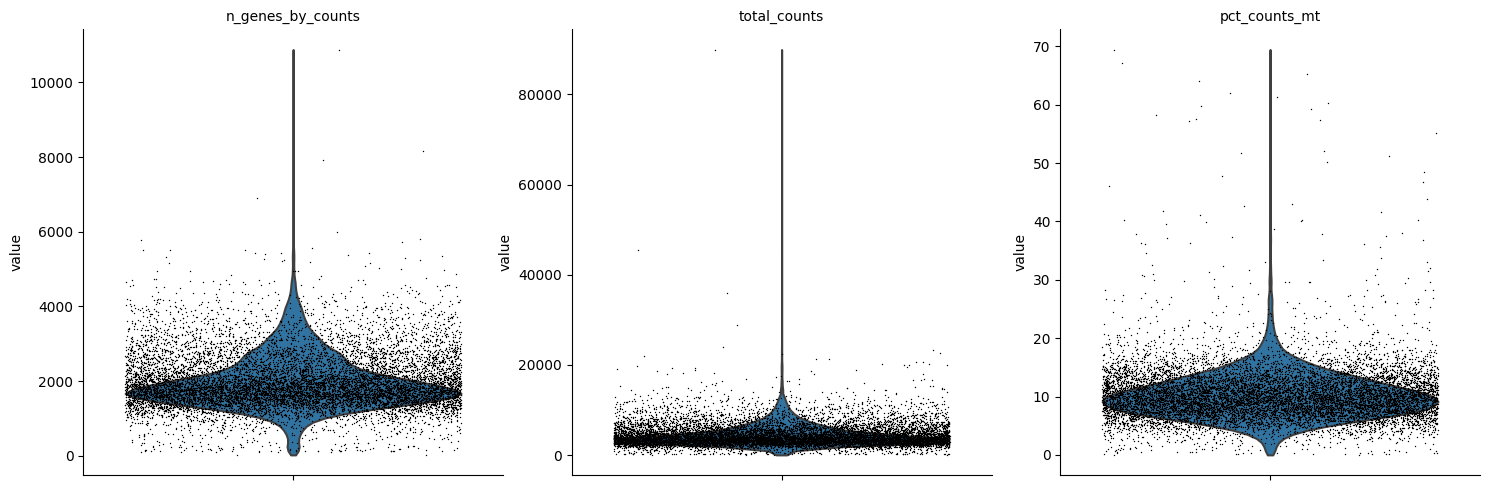

In [7]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [8]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

In [9]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

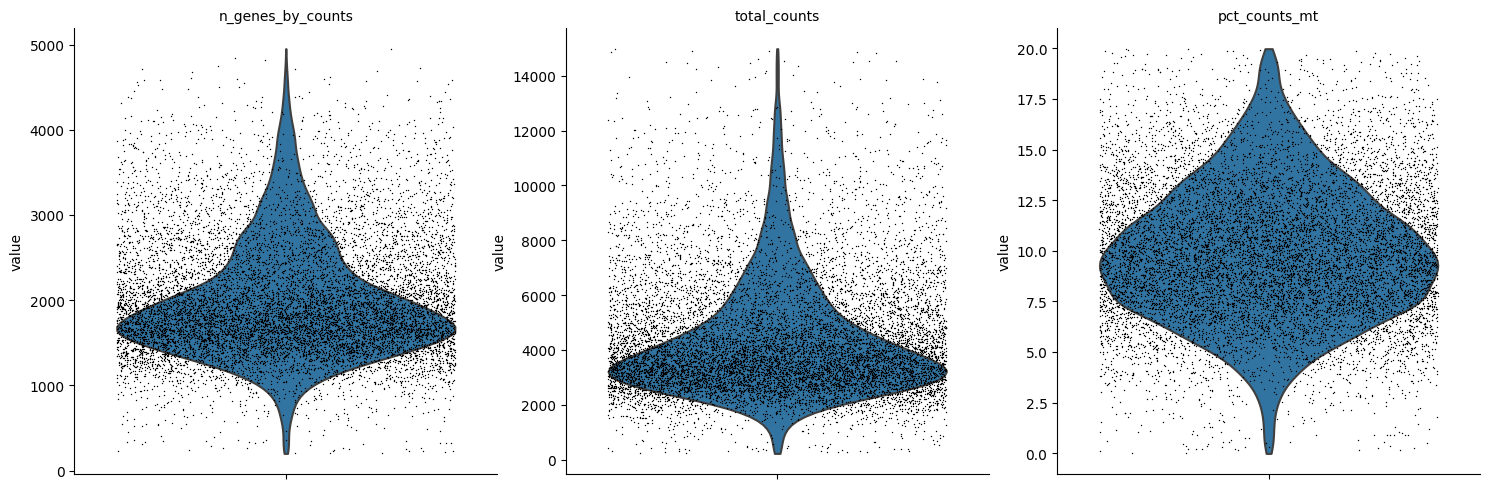

In [10]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [11]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [12]:
sc.pp.log1p(rna)

In [13]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

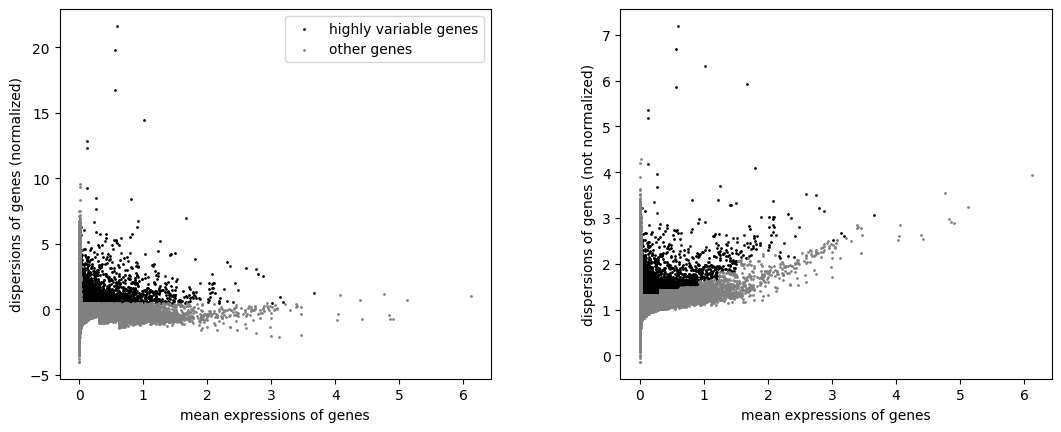

In [14]:
sc.pl.highly_variable_genes(rna)

In [15]:
np.sum(rna.var.highly_variable)

3026

In [16]:
rna.raw = rna

In [17]:
sc.pp.scale(rna, max_value=10)

In [18]:
sc.tl.pca(rna, svd_solver='arpack')

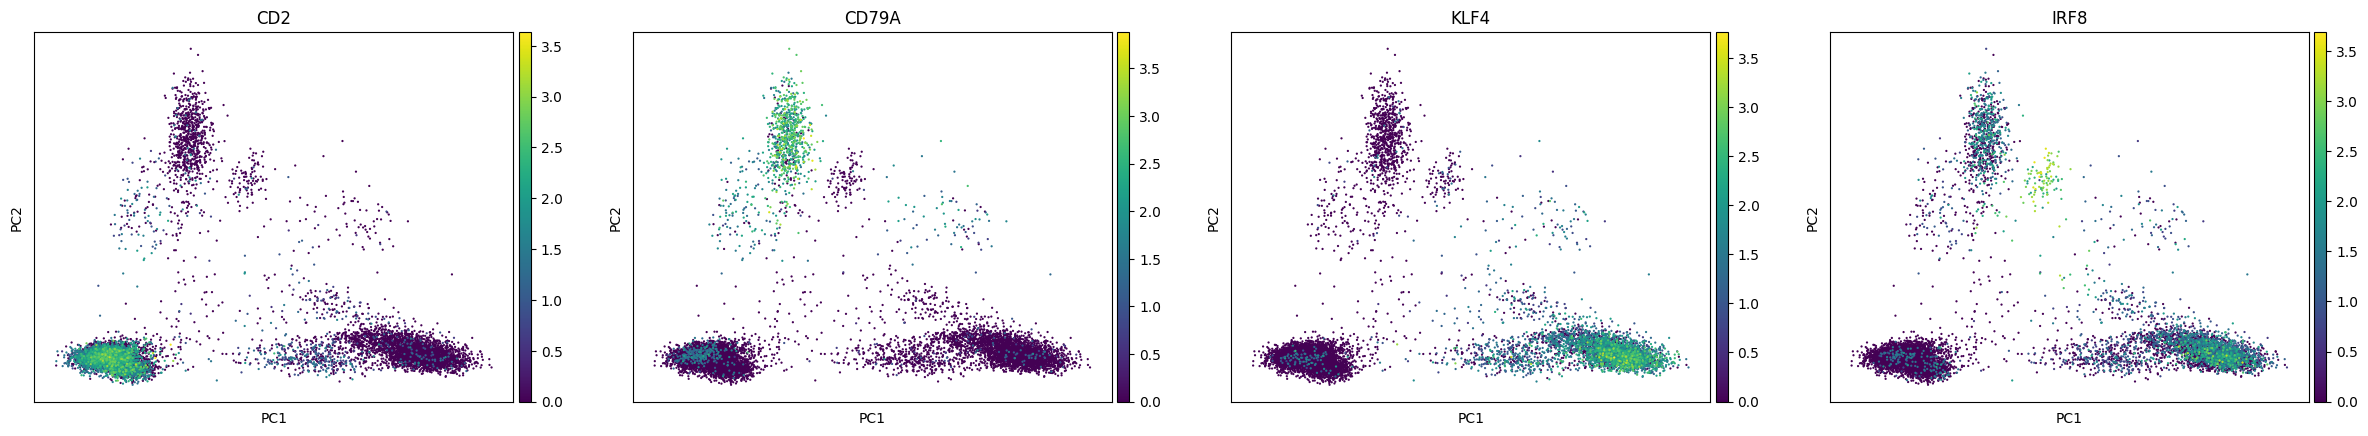

In [19]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

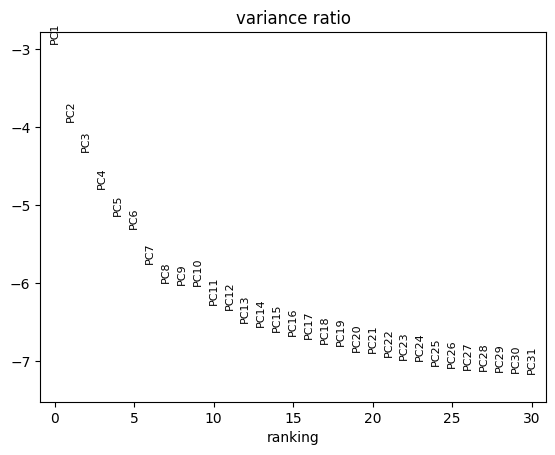

In [20]:
sc.pl.pca_variance_ratio(rna, log=True)

In [21]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

In [22]:
sc.tl.leiden(rna, resolution=.5)

In [23]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


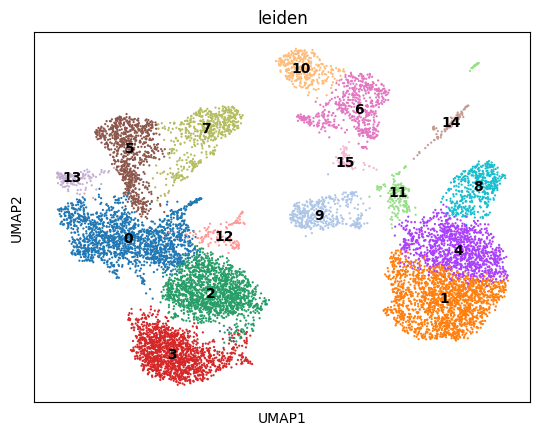

In [24]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

In [25]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

In [26]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p
0,INPP4B,0.000000e+00,PLXDC2,0.0,LEF1,0.000000e+00,LEF1,0.000000e+00,SLC8A1,0.0,CCL5,0.000000e+00,BANK1,0.000000e+00,GNLY,0.000000e+00,TCF7L2,0.000000e+00,NEAT1,4.718791e-212,IGHM,1.717810e-288,CD74,1.861813e-90,RPS27,3.403327e-23,SLC4A10,1.467181e-55,TCF4,2.131726e-108,BANK1,3.763632e-47
1,IL32,0.000000e+00,VCAN,0.0,BCL11B,0.000000e+00,BACH2,0.000000e+00,AOAH,0.0,NKG7,9.400807e-265,CD74,0.000000e+00,NKG7,1.176723e-284,PSAP,0.000000e+00,PLXDC2,2.628607e-182,AFF3,7.544332e-270,HLA-DPB1,2.860325e-81,RPL13,1.627878e-22,NKG7,5.864145e-48,RHEX,9.108035e-85,AFF3,3.540131e-43
2,LTB,0.000000e+00,DPYD,0.0,BACH2,0.000000e+00,PDE3B,0.000000e+00,PLXDC2,0.0,IL32,2.851434e-269,RALGPS2,2.564288e-316,CD247,8.015560e-287,LYN,0.000000e+00,ZEB2,7.727225e-167,BANK1,4.769351e-241,HLA-DRA,1.469804e-79,RPS26,1.102095e-21,PHACTR2,7.827522e-47,IRF8,2.498884e-83,CD74,4.056816e-40
3,SYNE2,0.000000e+00,ARHGAP26,0.0,CAMK4,0.000000e+00,THEMIS,0.000000e+00,TYMP,0.0,SYNE2,1.308115e-204,AFF3,1.996288e-313,PRF1,2.511484e-227,SAT1,0.000000e+00,LYST,6.523805e-153,CD74,1.556806e-232,HLA-DRB1,1.515022e-76,RPS14,2.776577e-21,RORA,8.299832e-44,FCHSD2,1.102102e-83,MARCH1,3.041281e-38
4,ANK3,0.000000e+00,LRMDA,0.0,FHIT,0.000000e+00,NELL2,0.000000e+00,DPYD,0.0,PRKCH,5.932643e-195,MS4A1,1.361493e-278,KLRD1,3.203748e-177,MTSS1,6.945663e-299,DPYD,1.410996e-156,FCRL1,6.639306e-170,HLA-DPA1,2.345964e-74,RPS12,3.946688e-20,SYNE2,6.569059e-42,UGCG,2.849758e-78,LYN,1.349819e-37
5,CDC14A,0.000000e+00,NEAT1,0.0,MALAT1,0.000000e+00,BCL11B,0.000000e+00,NEAT1,0.0,GZMA,1.125370e-170,OSBPL10,8.911800e-228,GZMA,1.293044e-171,CST3,1.766522e-289,SLC8A1,1.506366e-141,RALGPS2,3.628682e-166,AFF3,1.875145e-73,RPS29,1.077821e-18,IL7R,1.244422e-37,AFF3,3.814395e-81,HLA-DRA,1.141581e-35
6,IL7R,0.000000e+00,FCN1,0.0,RPS27A,0.000000e+00,CAMK4,0.000000e+00,ZEB2,0.0,SKAP1,1.235567e-177,HLA-DRA,6.100705e-255,SYNE1,7.231513e-166,WARS,6.182526e-282,TYMP,1.073277e-145,HLA-DRA,5.218855e-177,GAPDH,9.889435e-73,RPL28,2.123781e-14,SKAP1,6.381039e-37,CD74,5.871105e-85,PLXDC2,9.282713e-33
7,ITGB1,5.411181e-312,ZEB2,0.0,TCF7,1.934912e-292,CD8B,9.841788e-321,JAK2,0.0,A2M,5.869180e-161,CD79A,1.017956e-225,PRKCH,6.450976e-174,CTSS,5.129190e-313,LYN,1.311265e-143,BACH2,8.734895e-164,CST3,2.543705e-70,RPS21,6.182699e-14,A2M,7.265244e-36,PLD4,6.527479e-73,MEF2C,5.807980e-31
8,ARHGAP15,0.000000e+00,CSF3R,0.0,RPS27,1.342422e-310,OXNAD1,0.000000e+00,FCN1,0.0,SYNE1,4.622292e-159,PAX5,4.409159e-221,CTSW,8.702643e-161,COTL1,5.614600e-275,FCN1,3.184474e-135,PAX5,3.466932e-149,CCDC88A,5.261331e-70,RPL31,7.068589e-14,CCL5,2.003148e-35,BCL11A,1.199667e-67,MS4A1,2.406744e-30
9,BCL11B,0.000000e+00,DENND1A,0.0,INPP4B,2.152020e-279,TXK,6.099853e-318,LYN,0.0,HLA-B,3.258079e-164,BLK,1.280630e-195,MCTP2,7.675633e-155,TYMP,1.373828e-293,AOAH,1.301608e-141,MS4A1,3.121565e-133,HLA-DRB5,1.087053e-67,RPS23,1.052583e-13,KLRB1,5.005489e-35,RABGAP1L,1.325866e-70,PRKCB,5.573921e-30


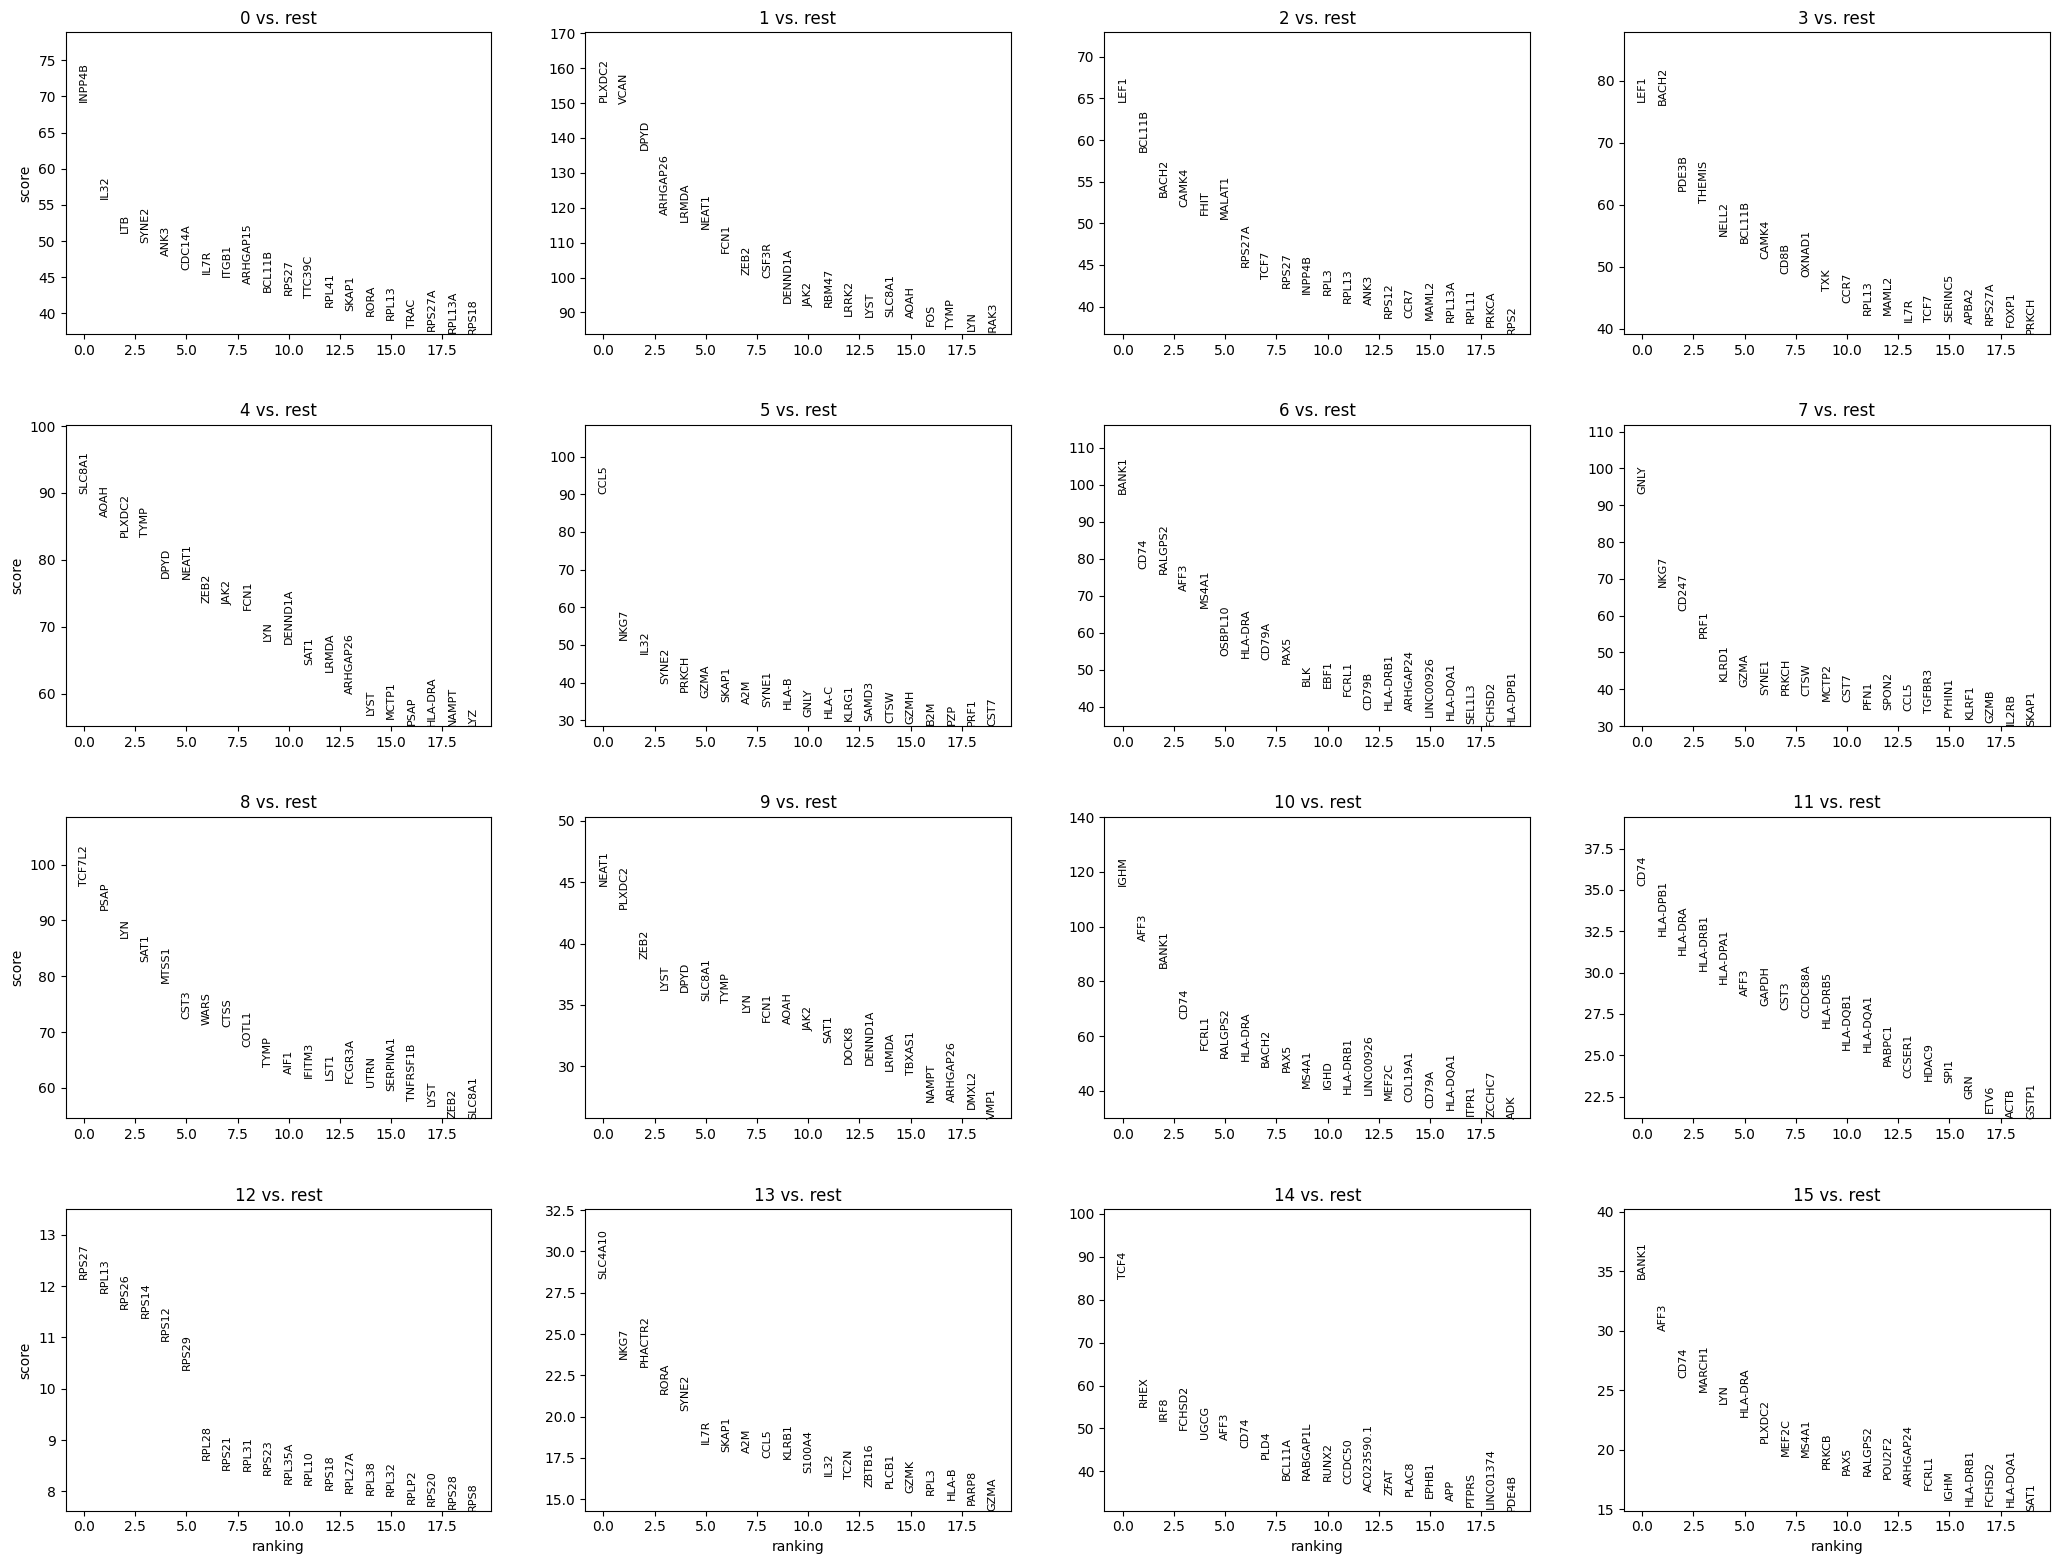

In [27]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

In [28]:
mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "15", "12", "16"]))
# Analogous to
#   rna = rna[~rna.obs.leiden.isin(["9", "15", "12", "16"])]
# but doesn't copy the object

In [29]:
new_cluster_names = {
    "0": "CD4+ memory T", "1": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "7": "NK", "13": "MAIT",
    "6": "memory B", "10": "naïve B",
    "4": "CD14 mono", "2": "intermediate mono", "8": "CD16 mono",
    "11": "mDC", "14": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)

In [30]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

/var/folders/w0/jwr8d6p948jcw0c8d5hwzmcr0000gn/T/ipykernel_38766/2053379708.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  rna.obs.celltype.cat.reorder_categories([


In [31]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


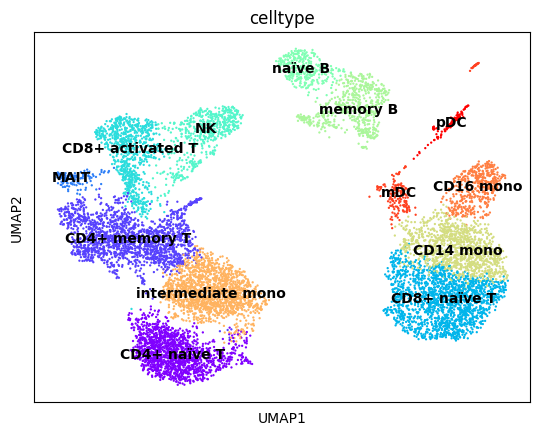

In [32]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

In [33]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'SLC4A10',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'CLEC10A', 'IRF8', 'TCF4']

/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


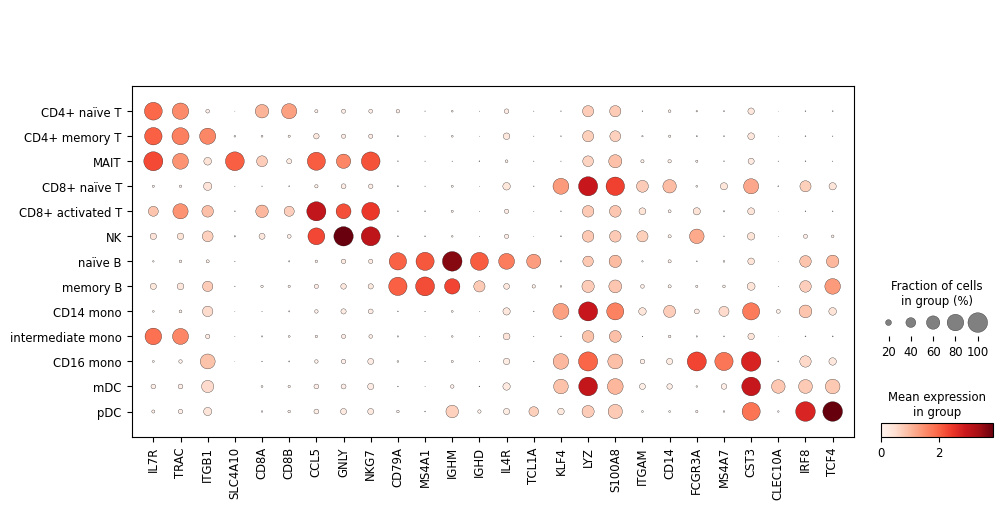

In [34]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

In [35]:
#mdata.write("pbmc10k.h5mu")

In [36]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

In [37]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

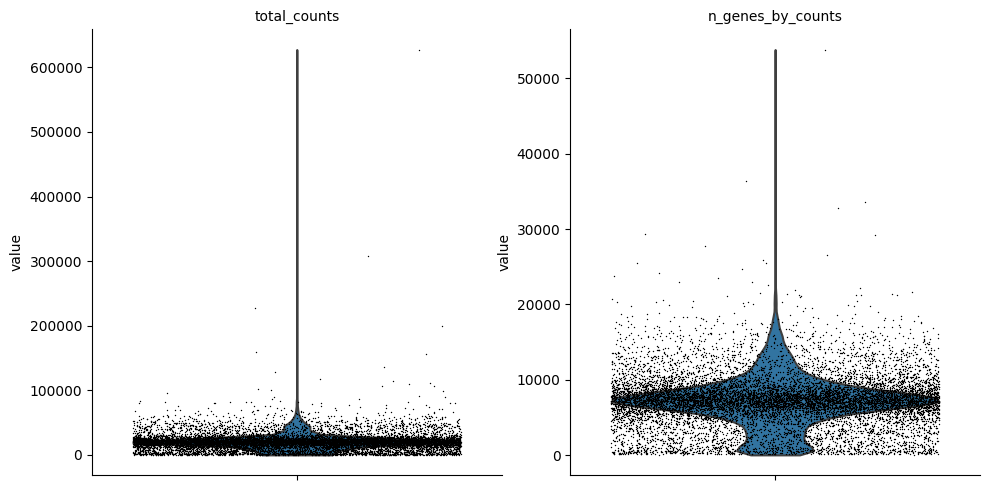

In [38]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [39]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [40]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

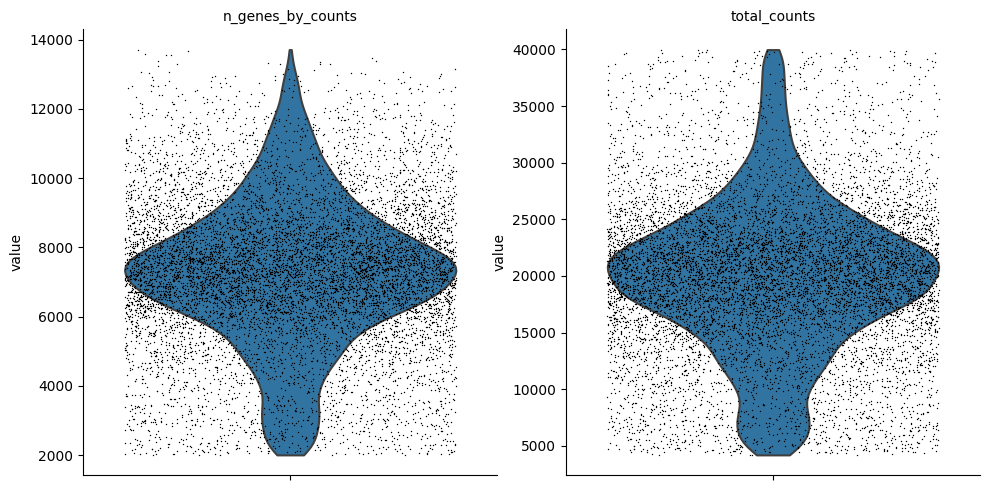

In [41]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

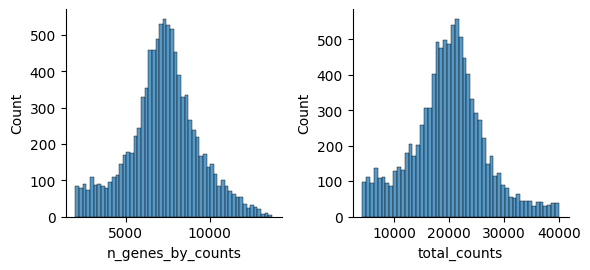

In [42]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

In [43]:
atac.obs['NS']=1

In [44]:
from muon import atac as ac

Fetching Regions...: 100%|███████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


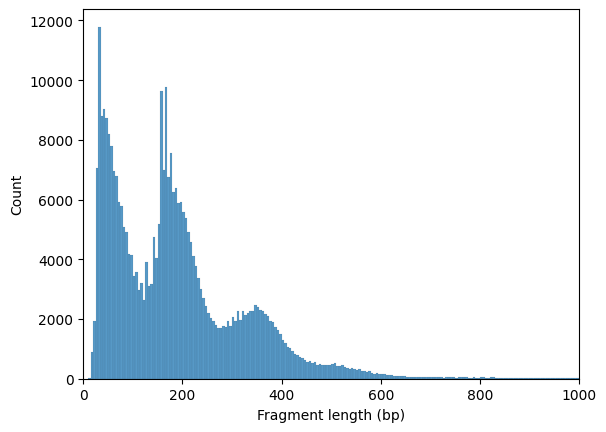

In [45]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [46]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|█████████████████████████████| 1000000/1000000 [00:02<00:00, 395581.02it/s]


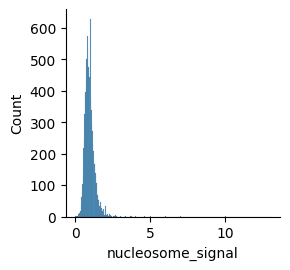

In [47]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

In [48]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL627309.4,chr1,160445,160446,ENSG00000241599,AL627309.4


In [49]:
atac.layers["counts"] = atac.X

In [50]:
ac.pp.tfidf(atac, scale_factor=1e4)

In [51]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

In [52]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

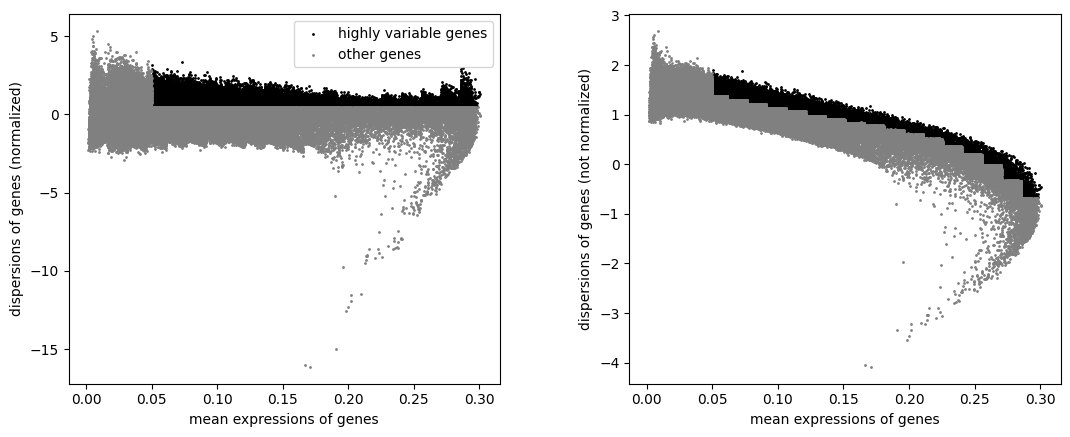

In [53]:
sc.pl.highly_variable_genes(atac)

In [54]:
np.sum(atac.var.highly_variable)

19430

In [55]:
atac.raw = atac

In [56]:
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'atac', 'files', 'log1p', 'hvg'
    layers: 'counts'

In [57]:
import anndata
import Bio
from pyjaspar import jaspardb
import pychromvar as pc
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns
import re

In [58]:
pc.add_peak_seq(atac, genome_file="/Users/zhijianli/rgtdata/hg38/genome_hg38.fa", delimiter=":|-")

100%|███████████████████████████████████████████████████| 106086/106086 [00:03<00:00, 34093.71it/s]


In [59]:
pc.add_gc_bias(atac)

100%|███████████████████████████████████████████████████| 106086/106086 [00:01<00:00, 72384.06it/s]


In [60]:
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'atac', 'files', 'log1p', 'hvg', 'seq'
    varm: 'gc_bias'
    layers: 'counts'

In [61]:
pc.get_bg_peaks(atac)

In [62]:
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'atac', 'files', 'log1p', 'hvg', 'seq'
    varm: 'gc_bias', 'bg_peaks'
    layers: 'counts'

In [63]:
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

In [64]:
pc.match_motif(atac, motifs=motifs)

100%|████████████████████████████████████████████████████| 106086/106086 [01:41<00:00, 1049.59it/s]


In [ ]:
%%time
pc.compute_deviations(atac)